In [1]:
import keypress_recognition.models as models
from keypress_recognition import dataset_p as dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
concat = False
delta = 3 if concat else 1
channels = 3 * delta

In [3]:
bmodel = models.get_black_bundle_model(channels)

In [4]:
dataset.load_all_data(color=['black'], size=['bundle'], keypress=True, concatenate=concat, delta=delta)

Start seperating keyboard ...
  White single width: 21px
  Black single width: 20px
  White bundle width: 37px
  Black bundle width: 36px


IntProgress(value=0, max=14273)

In trainset: 
  # of pressed black key: 8755
  # of unpressed black key: 44305


IntProgress(value=0, max=5000)

In testset: 
  # of pressed black key: 761
  # of unpressed black key: 22555


IntProgress(value=0, max=2993)

In valset: 
  # of pressed black key: 817
  # of unpressed black key: 10978


In [5]:
def visualize_keys(note):
    """
    note: bool
    return: str
    """
    return ("Y" if note else "N")

def display_concat_img(img, idx=None):
    if concat:
        if idx is None:
            return img[:, :, :, 3:6]
        else:
            return img[idx, :, :, 3:6]
    if idx is None:
        return img
    else:
        return img[idx, :, :, :]


Samples from X_train: 


IntProgress(value=0, max=88610)

(2, 106, 36, 3)
1 0
Samples from X_test: 


IntProgress(value=0, max=45110)

(2, 106, 36, 3)
1 0
Samples from X_val: 


IntProgress(value=0, max=21956)

(2, 106, 36, 3)
1 0


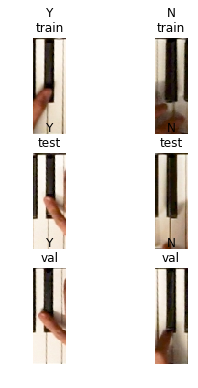

In [6]:
# print several images with labels
fig, axarr = plt.subplots(3, 2, figsize=[4, 6])
for ii, _type in enumerate(['train', 'test', 'val']):

    print(f'Samples from X_{_type}: ')

    for imgb, noteb in dataset.data_batch(type=_type, size='bundle', color='black', batch_size=2, NCHW=False, need_velocity=False, concatenate=concat):
        print(imgb.shape)
        print(noteb[0], noteb[1])
        axarr[ii,0].imshow(cv2.cvtColor(display_concat_img(imgb, 0), cv2.COLOR_BGR2RGB))
        axarr[ii,0].set_title(visualize_keys(noteb[0]) + '\n' + _type)
        axarr[ii,0].axis('off')
        axarr[ii,1].imshow(cv2.cvtColor(display_concat_img(imgb, 1), cv2.COLOR_BGR2RGB))
        axarr[ii,1].set_title(visualize_keys(noteb[1]) + '\n' + _type)
        axarr[ii,1].axis('off')
        break

plt.show()

In [7]:
bmodel.train(dataset, batch_size=32, size='bundle', color='black',
             concatenate=concat,
             num_epochs=20,
             max_num=-1,
             learning_rate=5e-4,
             weight_decay=0.05,
             decay_every=10,
             best_path='keypress_recognition/best_black_bundle_model.tar',
             current_path='keypress_recognition/current_black_bundle.tar',
             method=1)

Epoch 1/20


IntProgress(value=0, max=88610)

train Loss: 0.2804
[[41551  2158]
 [ 2769 42162]]
Precision: 0.94
Recall   : 0.95
Accuracy : 0.94


IntProgress(value=0, max=21956)

val Loss: 0.2466
[[10253    67]
 [  739 10925]]
Precision: 0.94
Recall   : 0.99
Accuracy : 0.96
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 2/20


IntProgress(value=0, max=88610)

train Loss: 0.2389
[[41942  1727]
 [ 2378 42593]]
Precision: 0.95
Recall   : 0.96
Accuracy : 0.95


IntProgress(value=0, max=21956)

val Loss: 0.3413
[[ 9626    14]
 [ 1366 10978]]
Precision: 0.89
Recall   : 1.00
Accuracy : 0.94
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 3/20


IntProgress(value=0, max=88610)

train Loss: 0.2263
[[42083  1637]
 [ 2237 42683]]
Precision: 0.95
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.2590
[[10058    13]
 [  934 10979]]
Precision: 0.92
Recall   : 1.00
Accuracy : 0.96
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 4/20


IntProgress(value=0, max=88610)

train Loss: 0.2234
[[42103  1651]
 [ 2217 42669]]
Precision: 0.95
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.1829
[[10532   225]
 [  460 10767]]
Precision: 0.96
Recall   : 0.98
Accuracy : 0.97
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 5/20


IntProgress(value=0, max=88610)

train Loss: 0.2192
[[42145  1645]
 [ 2175 42675]]
Precision: 0.95
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.1899
[[10784   323]
 [  208 10669]]
Precision: 0.98
Recall   : 0.97
Accuracy : 0.98
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 6/20


IntProgress(value=0, max=88610)

train Loss: 0.2171
[[42168  1712]
 [ 2152 42608]]
Precision: 0.95
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.1782
[[10757   162]
 [  235 10830]]
Precision: 0.98
Recall   : 0.99
Accuracy : 0.98
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 7/20


IntProgress(value=0, max=88610)

train Loss: 0.2136
[[42358  1613]
 [ 1962 42707]]
Precision: 0.96
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.1966
[[10554   214]
 [  438 10778]]
Precision: 0.96
Recall   : 0.98
Accuracy : 0.97
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 8/20


IntProgress(value=0, max=88610)

train Loss: 0.2132
[[42385  1594]
 [ 1935 42726]]
Precision: 0.96
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.2835
[[10667   541]
 [  325 10451]]
Precision: 0.97
Recall   : 0.95
Accuracy : 0.96
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 9/20


IntProgress(value=0, max=88610)

train Loss: 0.2148
[[42245  1563]
 [ 2075 42757]]
Precision: 0.95
Recall   : 0.96
Accuracy : 0.96


IntProgress(value=0, max=21956)

val Loss: 0.1644
[[10650   230]
 [  342 10762]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.97
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 10/20


IntProgress(value=0, max=88610)

train Loss: 0.1689
[[42872  1090]
 [ 1448 43230]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.97


IntProgress(value=0, max=21956)

val Loss: 0.1493
[[10775   254]
 [  217 10738]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 12/20


IntProgress(value=0, max=88610)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train Loss: 0.1520
[[43058   891]
 [ 1262 43429]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1309
[[10722   213]
 [  270 10779]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 14/20


IntProgress(value=0, max=88610)

train Loss: 0.1481
[[43132   873]
 [ 1188 43447]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1334
[[10763   226]
 [  229 10766]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 15/20


IntProgress(value=0, max=88610)

train Loss: 0.1438
[[43136   808]
 [ 1184 43512]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1191
[[10728   201]
 [  264 10791]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 16/20


IntProgress(value=0, max=88610)

train Loss: 0.1416
[[43157   764]
 [ 1163 43556]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1228
[[10721   227]
 [  271 10765]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 17/20


IntProgress(value=0, max=88610)

train Loss: 0.1388
[[43205   719]
 [ 1115 43601]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1143
[[10714   176]
 [  278 10816]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.98
The best model has been saved to keypress_recognition/best_black_bundle_model.tar ...
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 18/20


IntProgress(value=0, max=88610)

train Loss: 0.1360
[[43211   699]
 [ 1109 43621]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1252
[[10771   201]
 [  221 10791]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 19/20


IntProgress(value=0, max=88610)

train Loss: 0.1336
[[43222   665]
 [ 1098 43655]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1171
[[10712   173]
 [  280 10819]]
Precision: 0.97
Recall   : 0.98
Accuracy : 0.98
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Epoch 20/20


IntProgress(value=0, max=88610)

train Loss: 0.1314
[[43239   634]
 [ 1081 43686]]
Precision: 0.98
Recall   : 0.99
Accuracy : 0.98


IntProgress(value=0, max=21956)

val Loss: 0.1194
[[10758   186]
 [  234 10806]]
Precision: 0.98
Recall   : 0.98
Accuracy : 0.98
Current mode has been saved to keypress_recognition/current_black_bundle.tar ...

Training complete in 32m 26s
Best val loss: 0.114320


IntProgress(value=0, max=45110)

(12, 106, 36, 3)
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)


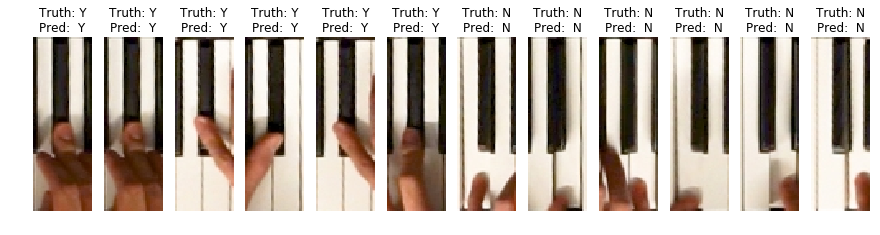

In [8]:
example_batch = 12
fig, axarr = plt.subplots(1, example_batch, figsize=(15,4))
for imgb, noteb in dataset.data_batch(type='test', size='bundle', color='black', batch_size=example_batch, NCHW=True, need_velocity=False, concatenate=concat):
    yb = bmodel.evaluate(imgb, threshold=0.5)
    imgb = np.transpose(imgb, (0, 2, 3, 1))
    print(imgb.shape)
    print(yb)
    for i in range(example_batch):
        axarr[i].imshow(cv2.cvtColor(display_concat_img(imgb, i), cv2.COLOR_BGR2RGB))
        axarr[i].set_title('Truth: ' + visualize_keys(noteb[i]) + '\nPred:  ' + visualize_keys(yb[i]))
        axarr[i].axis('off')
    break
plt.show()